In [ ]:
!pip install datasets==3.6.0
!pip install jiwer
!pip install -U openai-whisper
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 21.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=1171bfda4399a05669e9339bf2078413a108632c73f4ad3ca153c1ff41d50fd0
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset_builder, Split
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler, RandomSampler, SequentialSampler
import torchaudio
import os
import torch
import soundfile as sf
import numpy as np
from datasets import Audio
import whisper
import jiwer
from datasets import Dataset
from torch.utils.data import WeightedRandomSampler
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
# Explicit builder
builder = load_dataset_builder(
    "tobiolatunji/afrispeech-200",
    name="pidgin"
)

# Run dataset script
builder.download_and_prepare()

# Create dataset
pidgin_speech = builder.as_dataset()

train_ds = pidgin_speech[Split.TRAIN]
dev_ds   = pidgin_speech[Split.VALIDATION]
test_ds  = pidgin_speech[Split.TEST]

# DataLoader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
dev_loader   = DataLoader(dev_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [ ]:
SUBGROUP_COLS = ["age_group", "gender", "domain"]

def add_subgroup(example):
    example["subgroup"] = "|".join(
        str(example[c]) for c in SUBGROUP_COLS
    )
    return example

train_ds = train_ds.map(add_subgroup)
dev_ds   = dev_ds.map(add_subgroup)
test_ds  = test_ds.map(add_subgroup)

In [ ]:
train_df = train_ds.to_pandas()
dev_df   = dev_ds.to_pandas()
test_df  = test_ds.to_pandas()

In [ ]:
train_df.head()

,speaker_id,path,audio_id,audio,transcript,age_group,gender,accent,domain,country,duration
0,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3...,{'bytes': b'RIFF\xdc\xc3\x17\x00WAVEfmt \x10\x...,Pt had been given ambient at 1am for complaint...,19-25,Male,pidgin,clinical,NG,8.828979
1,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5...,{'bytes': b'RIFF0\x86\x18\x00WAVEfmt \x10\x00\...,"For example, immuno blotting analysis will det...",19-25,Male,pidgin,clinical,NG,9.110998
2,6b8b5e193a89f7d1994a56d55ad90c7e,/root/.cache/huggingface/datasets/downloads/ex...,db822b6a-8a98-4771-9cf1-6ca9bc977362/0236ac5cc...,{'bytes': b'RIFFl\x87\t\x00WAVEfmt \x10\x00\x0...,Coronary arteries are extensively calcified.,26-40,Female,pidgin,clinical,NG,3.540000
3,2cccaf777b988e7242fafa0ff3ed7972,/root/.cache/huggingface/datasets/downloads/ex...,867c16a5-20c7-4881-ba19-03e7b967f146/f09cc6805...,{'bytes': b'RIFF\x9c\xe5\x19\x00WAVEfmt \x10\x...,"Kizz has been known for dropping hit songs, so...",56yrs>,Male,pidgin,general,NG,9.620997
4,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,05a6e5ac-79fe-4e20-9fc2-20ad0f39e0d0/eeb55bbb2...,{'bytes': b'RIFF\xe0\x12*\x00WAVEfmt \x10\x00\...,"And, according to The Sun, Prince Harry has al...",19-25,Male,pidgin,general,NG,15.630998


In [ ]:
from collections import Counter

subgroup_counts = Counter(train_df["subgroup"])

In [ ]:
train_df["sample_weight"] = train_df["subgroup"].apply(
    lambda g: 1.0 / subgroup_counts[g]
)
train_df["sample_weight"] /= train_df["sample_weight"].sum()

In [ ]:
def add_sample_weight(example):
    key = f"{example['age_group']}|{example['gender']}|{example['domain']}"
    example["sample_weight"] = 1.0 / subgroup_counts[key]
    return example

train_ds = train_ds.map(add_sample_weight)

In [ ]:
weights = torch.tensor(train_ds["sample_weight"], dtype=torch.double)

generator = torch.Generator()
generator.manual_seed(42)

sampler = WeightedRandomSampler(
    weights,
    num_samples=len(weights),
    replacement=True,
    generator=generator
)

In [ ]:
train_df.head()

,speaker_id,path,audio_id,audio,transcript,age_group,gender,accent,domain,country,duration
0,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3...,{'bytes': b'RIFF\xdc\xc3\x17\x00WAVEfmt \x10\x...,Pt had been given ambient at 1am for complaint...,19-25,Male,pidgin,clinical,NG,8.828979
1,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5...,{'bytes': b'RIFF0\x86\x18\x00WAVEfmt \x10\x00\...,"For example, immuno blotting analysis will det...",19-25,Male,pidgin,clinical,NG,9.110998
2,6b8b5e193a89f7d1994a56d55ad90c7e,/root/.cache/huggingface/datasets/downloads/ex...,db822b6a-8a98-4771-9cf1-6ca9bc977362/0236ac5cc...,{'bytes': b'RIFFl\x87\t\x00WAVEfmt \x10\x00\x0...,Coronary arteries are extensively calcified.,26-40,Female,pidgin,clinical,NG,3.540000
3,2cccaf777b988e7242fafa0ff3ed7972,/root/.cache/huggingface/datasets/downloads/ex...,867c16a5-20c7-4881-ba19-03e7b967f146/f09cc6805...,{'bytes': b'RIFF\x9c\xe5\x19\x00WAVEfmt \x10\x...,"Kizz has been known for dropping hit songs, so...",56yrs>,Male,pidgin,general,NG,9.620997
4,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,05a6e5ac-79fe-4e20-9fc2-20ad0f39e0d0/eeb55bbb2...,{'bytes': b'RIFF\xe0\x12*\x00WAVEfmt \x10\x00\...,"And, according to The Sun, Prince Harry has al...",19-25,Male,pidgin,general,NG,15.630998


In [ ]:
train_df.count()

,0
speaker_id,439
path,439
audio_id,439
audio,439
transcript,439
age_group,439
gender,439
accent,439
domain,439
country,439


In [ ]:
from datasets import Audio

train_ds = train_ds.cast_column(
    "audio", Audio(sampling_rate=16000)
)
test_ds = test_ds.cast_column(
    "audio", Audio(sampling_rate=16000)
)
dev_ds = dev_ds.cast_column(
    "audio", Audio(sampling_rate=16000)
)

In [ ]:
ex = train_ds[0]
print(ex["audio"]["sampling_rate"])

16000


In [ ]:
from IPython.display import Audio, display

ex = train_ds[1]

display(Audio(
    data=ex["audio"]["array"],
    rate=ex["audio"]["sampling_rate"]
))

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,        # fairness-aware
    shuffle=False           # sampler handles randomness
)

dev_loader = DataLoader(
    dev_ds,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False
)

In [ ]:
model_id = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="en", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(model_id)

In [ ]:
model.generation_config.language = "en"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

In [ ]:
sample = next(iter(train_ds))
input_features = processor(sample["audio"]["array"], return_tensors="pt").input_features
pred_ids = model.generate(input_features)
pred_text = processor.batch_decode(pred_ids)
print(pred_text)

It is strongly recommended to pass the `sampling_rate` argument to `WhisperFeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


[' Patients had been given ambience at 1 a.m. for complaints of being unable to sleep']


In [ ]:
def prepare_dataset(batch):
  audio = batch["audio"]

  batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

  batch["labels"] = processor.tokenizer(batch["transcript"]).input_ids

  return batch

In [ ]:
COLUMNS_TO_REMOVE = ["audio", "transcript", "speaker_id", "path", "audio_id", "duration", "accent", "country"]

In [ ]:
train_ds_p = train_ds.map(prepare_dataset, remove_columns=train_ds.column_names)
dev_ds_p   = dev_ds.map(prepare_dataset, remove_columns=dev_ds.column_names)

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [ ]:
train_ds_p.features

{'input_features': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [ ]:
import re
import evaluate

metric = evaluate.load("wer")

def normalize_text(s):
    s = s.lower().strip()
    s = re.sub(r"[^\w\s']", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]

    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    pred_str  = [normalize_text(s) for s in pred_str]
    label_str = [normalize_text(s) for s in label_str]

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

In [ ]:
train_ds_p[16]

{'input_features': [[-0.6111643314361572,
   -0.6111643314361572,
   -0.4244788885116577,
   -0.3057422637939453,
   -0.30046403408050537,
   0.07502686977386475,
   0.34147971868515015,
   0.6883396506309509,
   0.33108413219451904,
   -0.06093025207519531,
   0.07796913385391235,
   0.07554161548614502,
   0.09447526931762695,
   0.30633705854415894,
   -0.05473923683166504,
   -0.10501623153686523,
   -0.11754357814788818,
   0.1363484263420105,
   0.16875207424163818,
   -0.2175900936126709,
   0.17691802978515625,
   0.17607015371322632,
   -0.009667158126831055,
   -0.11411678791046143,
   0.05241125822067261,
   -0.03179931640625,
   -0.03819596767425537,
   -0.32038915157318115,
   -0.16323399543762207,
   -0.4402945041656494,
   -0.1169590950012207,
   -0.2369750738143921,
   -0.36705660820007324,
   -0.18986034393310547,
   -0.038639068603515625,
   -0.10502827167510986,
   -0.33578062057495117,
   -0.21745216846466064,
   -0.27579617500305176,
   -0.45889341831207275,
   -0.

In [ ]:
class FairSamplingWhisperTrainer(Seq2SeqTrainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            num_workers=0,
            pin_memory=False
        )

In [ ]:
from transformers import set_seed
SEED = 42
set_seed(SEED)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="whisper-pidgin-fair",

    seed=SEED,
    data_seed=SEED,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,

    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,
    num_train_epochs=20,

    fp16=True,

    dataloader_num_workers=0,
    dataloader_pin_memory=False,
    save_total_limit=2,

    eval_strategy="epoch",
    save_strategy="epoch",
    include_inputs_for_metrics=False,

    predict_with_generate=True,
    generation_max_length=225,

    logging_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    remove_unused_columns=False,
    disable_tqdm=False,
    label_names=["labels"],
    report_to=["tensorboard"],
)

In [ ]:
from transformers import EarlyStoppingCallback

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_ds_p,
    eval_dataset=dev_ds_p,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
)

/tmp/ipython-input-1087987362.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
import torch, platform
print("py", platform.python_version(), "torch", torch.__version__, "cuda", torch.version.cuda,
      "avail", torch.cuda.is_available())
x = torch.randn(1, device="cuda" if torch.cuda.is_available() else "cpu"); print("cuda_ok")

py 3.12.12 torch 2.9.0+cu126 cuda 12.6 avail True
cuda_ok


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
print(os.environ["CUDA_LAUNCH_BLOCKING"])

1


In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
trainer.train()

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Wer
1,3.911100,3.903061,49.823322
2,2.094000,2.407317,44.876325
3,1.101100,1.659936,41.342756
4,0.634300,1.584941,41.696113
5,0.341000,1.547668,41.342756
6,0.156500,1.595229,41.696113
7,0.077500,1.621755,41.342756
8,0.040100,1.628702,45.229682
9,0.032500,1.692836,42.756184


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=252, training_loss=0.932010324464904, metrics={'train_runtime': 674.3498, 'train_samples_per_second': 13.02, 'train_steps_per_second': 0.83, 'total_flos': 1.14020091666432e+18, 'train_loss': 0.932010324464904, 'epoch': 9.0})

In [ ]:
logs = trainer.state.log_history

In [ ]:
logs

[{'loss': 3.9111,
  'grad_norm': 42.13579177856445,
  'learning_rate': 1.62e-06,
  'epoch': 1.0,
  'step': 28},
 {'eval_loss': 3.9030609130859375,
  'eval_wer': 49.82332155477032,
  'eval_runtime': 6.88,
  'eval_samples_per_second': 3.779,
  'eval_steps_per_second': 0.581,
  'epoch': 1.0,
  'step': 28},
 {'loss': 2.094,
  'grad_norm': 18.331871032714844,
  'learning_rate': 3.3e-06,
  'epoch': 2.0,
  'step': 56},
 {'eval_loss': 2.4073166847229004,
  'eval_wer': 44.87632508833922,
  'eval_runtime': 6.7,
  'eval_samples_per_second': 3.881,
  'eval_steps_per_second': 0.597,
  'epoch': 2.0,
  'step': 56},
 {'loss': 1.1011,
  'grad_norm': 12.657631874084473,
  'learning_rate': 4.980000000000001e-06,
  'epoch': 3.0,
  'step': 84},
 {'eval_loss': 1.6599359512329102,
  'eval_wer': 41.342756183745585,
  'eval_runtime': 6.7822,
  'eval_samples_per_second': 3.834,
  'eval_steps_per_second': 0.59,
  'epoch': 3.0,
  'step': 84},
 {'loss': 0.6343,
  'grad_norm': 8.499258995056152,
  'learning_rate': 

In [ ]:
import pandas as pd

rows = []

for log in logs:
    row = {}
    if "loss" in log:
        row["epoch"] = log.get("epoch")
        row["train_loss"] = log["loss"]
    if "eval_wer" in log:
        row["epoch"] = log.get("epoch")
        row["wer"] = log["eval_wer"]
    if row:
        rows.append(row)

df = pd.DataFrame(rows)
df = df.groupby("epoch").mean().reset_index()
print(df)

   epoch  train_loss        wer
0    1.0      3.9111  49.823322
1    2.0      2.0940  44.876325
2    3.0      1.1011  41.342756
3    4.0      0.6343  41.696113
4    5.0      0.3410  41.342756
5    6.0      0.1565  41.696113
6    7.0      0.0775  41.342756
7    8.0      0.0401  45.229682
8    9.0      0.0325  42.756184


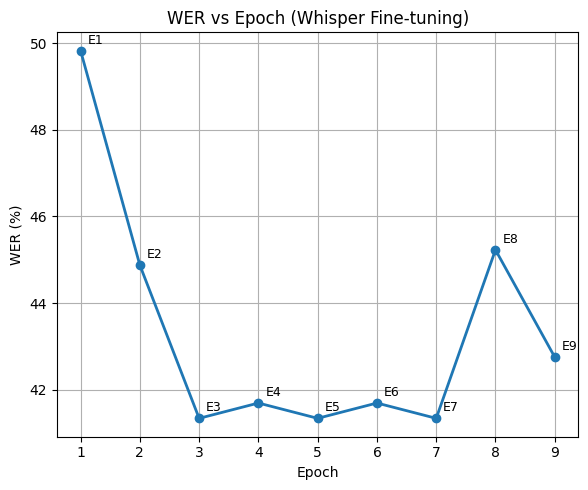

📁 Plot saved to: /content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42/wer_vs_epoch_Seed_23.png


In [ ]:
import os
import matplotlib.pyplot as plt

# keep only first 7 epochs
df_plot = df[df["epoch"] <= 10].sort_values("epoch")

plt.figure(figsize=(6,5))

plt.plot(
    df_plot["epoch"],
    df_plot["wer"],
    marker="o",
    linewidth=2
)

# annotate each point
for _, row in df_plot.iterrows():
    plt.annotate(
        f"E{int(row['epoch'])}",
        (row["epoch"], row["wer"]),
        textcoords="offset points",
        xytext=(5,5),
        fontsize=9
    )

plt.xlabel("Epoch")
plt.ylabel("WER (%)")
plt.title("WER vs Epoch (Whisper Fine-tuning)")
plt.grid(True)
plt.tight_layout()

# save
save_dir = "/content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "wer_vs_epoch_Seed_23.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"📁 Plot saved to: {save_path}")

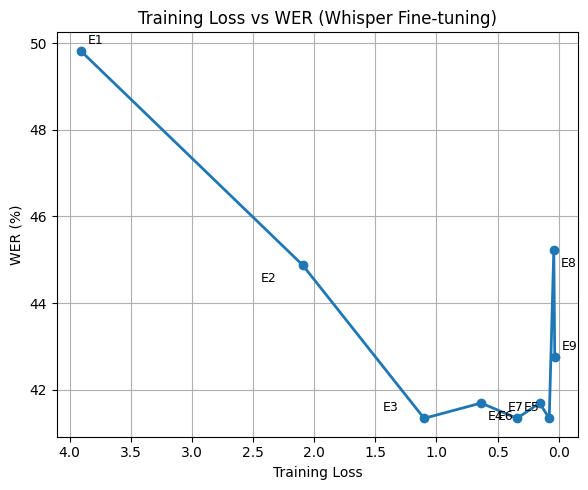

📁 Plot saved to: /content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42/training_loss_vs_wer_epoch_1_to_9.png


In [ ]:
import os
import matplotlib.pyplot as plt

df_plot = df[df["epoch"] <= 10].sort_values("epoch", ascending=False)

plt.figure(figsize=(6,5))

plt.plot(
    df_plot["train_loss"],
    df_plot["wer"],
    marker="o",
    linewidth=2
)

offsets = [(5, 5), (5, -12), (-30, 5), (-30, -12)]

for i, (_, row) in enumerate(df_plot.iterrows()):
    dx, dy = offsets[i % len(offsets)]
    plt.annotate(
        f"E{int(row['epoch'])}",
        (row["train_loss"], row["wer"]),
        textcoords="offset points",
        xytext=(dx, dy),
        fontsize=9
    )

plt.xlabel("Training Loss")
plt.ylabel("WER (%)")
plt.title("Training Loss vs WER (Whisper Fine-tuning)")
plt.grid(True)
plt.tight_layout()

plt.gca().invert_xaxis()

save_dir = "/content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "training_loss_vs_wer_epoch_1_to_9.png")

plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"📁 Plot saved to: {save_path}")


In [ ]:
model.eval()

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [ ]:
test_ds_p  = test_ds.map(prepare_dataset, remove_columns=test_ds.column_names)

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(test_ds_p)

In [ ]:
import numpy as np

pred_ids = predictions.predictions

# Some Trainer versions wrap predictions in a tuple
if isinstance(pred_ids, tuple):
    pred_ids = pred_ids[0]

pred_text = processor.tokenizer.batch_decode(
    pred_ids,
    skip_special_tokens=True
)

In [ ]:
test_df = test_df.reset_index(drop=True)
test_df["pred"] = pred_text

In [ ]:
overall_wer = jiwer.wer(
    test_df["transcript"].tolist(),
    test_df["pred"].tolist()
)

overall_cer = jiwer.cer(
    test_df["transcript"].tolist(),
    test_df["pred"].tolist()
)

print("Word Error Rate (WER):", overall_wer)
print("Character Error Rate (CER):", overall_cer)

Word Error Rate (WER): 0.3024251069900143
Character Error Rate (CER): 0.1539491298527443


In [ ]:
def wer_by_column(df, column):
    results = {}
    for val in df[column].dropna().unique():
        sub = df[df[column] == val]
        if len(sub) < 3:
            continue  # avoid noisy subgroups
        results[val] = jiwer.wer(sub["transcript"].tolist(), sub["pred"].tolist())
    return results

In [ ]:
wer_by_gender = wer_by_column(test_df, "gender")
wer_by_accent = wer_by_column(test_df, "accent")
wer_by_domain = wer_by_column(test_df, "domain")
wer_by_age    = wer_by_column(test_df, "age_group")

In [ ]:
print("Gender WER:", wer_by_gender)
print("Accent WER:", wer_by_accent)
print("Domain WER:", wer_by_domain)
print("Age Group WER:", wer_by_age)

Gender WER: {'Female': 0.31683168316831684, 'Male': 0.2914572864321608}
Accent WER: {'pidgin': 0.3024251069900143}
Domain WER: {'general': 0.3562091503267974, 'clinical': 0.2607594936708861}
Age Group WER: {'': 0.3216374269005848, '19-25': 0.25766871165644173, '41-55': 0.3114754098360656, '<18yrs': 0.3776223776223776}


In [ ]:
test_df["subgroup"] = (
    test_df[["age_group", "gender", "domain"]]
    .astype(str)
    .agg("|".join, axis=1)
)

wer_by_subgroup = wer_by_column(test_df, "subgroup")

In [ ]:
print(f"Intersectional Subgroup WER: {wer_by_subgroup}")

Intersectional Subgroup WER: {'|Female|general': 0.4, '19-25|Male|clinical': 0.28102189781021897, '|Male|general': 0.27358490566037735, '41-55|Female|clinical': 0.3114754098360656, '19-25|Female|clinical': 0.1346153846153846, '<18yrs|Female|general': 0.37606837606837606}


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = "/content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42"

In [ ]:
wer_results = {
    "config":{
        "Seed": 42,
        "modelName": "openai/whisper-small",
        "language": "en",
        "task": "transcribe",
        "fine-tuned": "yes",
        "fairness": "No",
        "Fairness Aware Training": "No",
        "Subgroup_Sampling": "No",
        "Compute Loss": "Loss Reweighting",
        "Custom Sampler": "N/A",
        "num_train_epochs": 20,
        "batch_size": 16,
        "learning_rate": 3e-5,
        "weight_decay": 0.01,
        "warmup_steps": 500,
        "fp16": True,
        "dataloader_num_workers": 0,
        "dataloader_pin_memory": False,
        "save_total_limit": 2,
        "eval_strategy": "epoch",
        "save_strategy": "epoch",
        "include_inputs_for_metrics": False,
        "predict_with_generate": True,
        "generation_max_length": 225,
        "logging_strategy": "epoch",
        "load_best_model_at_end": True,
        "metric_for_best_model": "wer",
        "greater_is_better": False,
        "remove_unused_columns": False,
        "disable_tqdm": False,
        "label_names": ["labels"],
        "report_to": ["tensorboard"],
        "early_stopping_patience": 6,
    },
    "ColabConfig":{
        "GPU": "A100 GPU",
        "RAM": "84GB",
        "CPU": "4 CPU",
    },
    "overall": {
        "wer": overall_wer,
        "cer": overall_cer,
    },
    "by_gender": wer_by_gender,
    "by_accent": wer_by_accent,
    "by_domain": wer_by_domain,
    "by_age_group": wer_by_age,
    "wer_by_subgroup": wer_by_subgroup,
}

In [ ]:
wer_results

{'config': {'Seed': 42,
  'modelName': 'openai/whisper-small',
  'language': 'en',
  'task': 'transcribe',
  'fine-tuned': 'yes',
  'fairness': 'No',
  'Fairness Aware Training': 'No',
  'Subgroup_Sampling': 'No',
  'Compute Loss': 'Loss Reweighting',
  'Custom Sampler': 'N/A',
  'num_train_epochs': 20,
  'batch_size': 16,
  'learning_rate': 3e-05,
  'weight_decay': 0.01,
  'warmup_steps': 500,
  'fp16': True,
  'dataloader_num_workers': 0,
  'dataloader_pin_memory': False,
  'save_total_limit': 2,
  'eval_strategy': 'epoch',
  'save_strategy': 'epoch',
  'include_inputs_for_metrics': False,
  'predict_with_generate': True,
  'generation_max_length': 225,
  'logging_strategy': 'epoch',
  'load_best_model_at_end': True,
  'metric_for_best_model': 'wer',
  'greater_is_better': False,
  'remove_unused_columns': False,
  'disable_tqdm': False,
  'label_names': ['labels'],
  'report_to': ['tensorboard'],
  'early_stopping_patience': 6},
 'ColabConfig': {'GPU': 'A100 GPU', 'RAM': '84GB', 'CP

In [ ]:
import json
import os

os.makedirs(BASE_DIR, exist_ok=True)

wer_path = os.path.join(BASE_DIR, "wer_results.json")
with open(wer_path, "w") as f:
    json.dump(wer_results, f, indent=2)

print("WER results saved to:", wer_path)

WER results saved to: /content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42/wer_results.json


In [ ]:
model_dir = os.path.join(BASE_DIR, "Whisper_Pidgin_FineTuned_No_Fair")

trainer.save_model(model_dir)
processor.tokenizer.save_pretrained(model_dir)
processor.feature_extractor.save_pretrained(model_dir)

print("Model saved to:", model_dir)

Model saved to: /content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42/Whisper_Pidgin_FineTuned_No_Fair


In [ ]:
import pandas as pd

logs = trainer.state.log_history

logs_df = pd.DataFrame(logs)

logs_json_path = os.path.join(BASE_DIR, "training_logs.json")
logs_csv_path  = os.path.join(BASE_DIR, "training_logs.csv")

logs_df.to_json(logs_json_path, orient="records", indent=2)
logs_df.to_csv(logs_csv_path, index=False)

print("Training logs saved to:")
print(logs_json_path)
print(logs_csv_path)

Training logs saved to:
/content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42/training_logs.json
/content/drive/MyDrive/Brock University/Pidgin_ASR_Results/No_Fair_Aware_Sampling_Seed_42/training_logs.csv
